<a href="https://colab.research.google.com/github/KartikChugh/MachineLearning/blob/master/regression_insurance_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Task: Medical Costs

In this project, we develop a data pipeline to handle the well-known [health insurance costs dataset](https://www.kaggle.com/mirichoi0218/insurance), and implement gradient-based and linear algebra solutions to perform linear regression.


***
##  Step 1: The Problem

In [ ]:
# Import some common packages
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# Setup matplotlib for graphical display
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)

Below is a preview of our dataset for this project. We will be building a regression model to predict medical costs given certain features.

In [ ]:
data = pd.read_csv('insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
feature_names = data.columns[:-1]
label_name = data.columns[-1]
print("Features:", feature_names.values)
print("Label:", label_name)

Features: ['age' 'sex' 'bmi' 'children' 'smoker' 'region']
Label: charges


The dataset consists of:
- 1338 entries
- 7 variables (6 features + 1 label)
- 3 categorical features
- 0 missing values  

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
num_feature_names = data.dtypes[data.dtypes != 'object'].index.drop(label_name)
cat_feature_names = data.dtypes[data.dtypes == 'object'].index
print("Numerical: ", num_feature_names.values)
print("Categorical: ", cat_feature_names.values)

Numerical:  ['age' 'bmi' 'children']
Categorical:  ['sex' 'smoker' 'region']


Below is a statistical summary of the numerical variables. 

Note, however, that two of these (age and children) are discrete data, which may result from phenomena vastly different from those of Gaussian-distributed data (e.g. Poisson processes). Therefore, we should be cautious in how we interpret the standard deviation.

In [ ]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


We can visualize our data to get a better look. Below, we see that of the 4 numerical variables, only BMI has a normal distribution, making its standard deviation of ~6 a useful measure of variation.

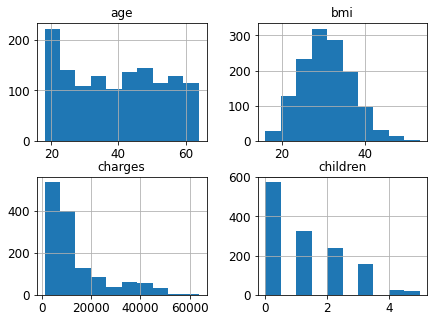

In [ ]:
data.hist(figsize=(7,5))
plt.show()

---
##  Step 2: Data Analysis & Preprocessing


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=SEED)

print(train.shape)
print(test.shape)

(1070, 7)
(268, 7)


We can inspect correlation scores with respect to the label to form conjectures about our predictors. It appears that **age may have some useful linear relationship with medical costs**, while number of children has essentially none.

In [ ]:
corr_matrix = train.corr()
corr_scores = pd.DataFrame(corr_matrix[label_name].sort_values(ascending=False))
corr_scores

,charges
charges,1.000000
age,0.281721
bmi,0.197316
children,0.071885


Our scatter matrix below confirms this, while revealing some interesting patterns. There appear to be three "lines" of medical costs, all trending upwards with age. BMI has two discernable clusters, while the number of children lacks a clear general relationship; the most that can be said is that families with 5 children have less variation in medical costs.

Note that these 2D plots necessarily lack the dimensionality of the full dataset. **Ideally, our machine learning model should be able to combine features to pick apart the separate trends** we see in the age plot.

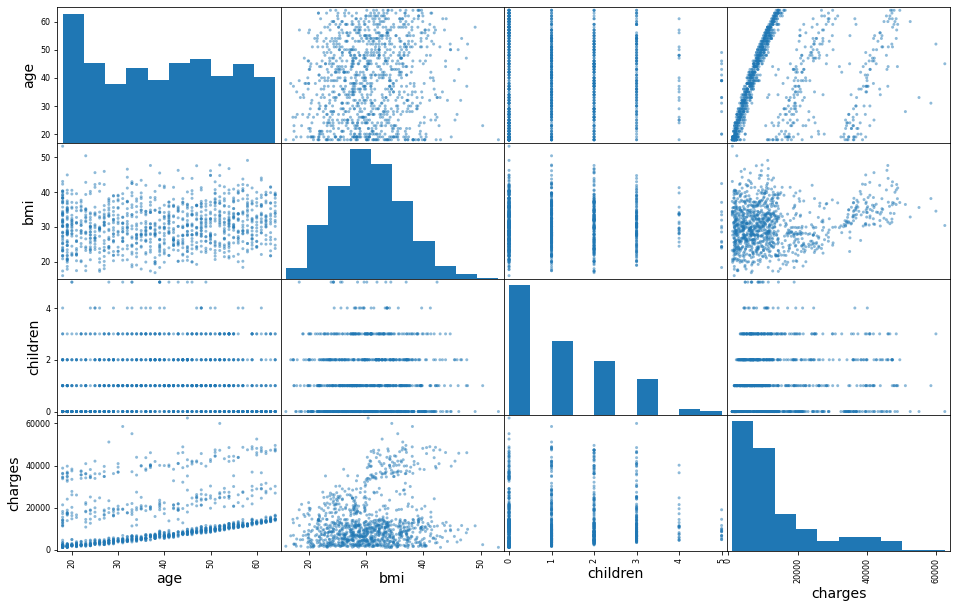

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(train, figsize=(16, 10))
plt.show()

We construct a data preprocessing pipeline to perform imputation and scaling on numerical features, and one-hot encoding on categorical features.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
  ('onehot', OneHotEncoder())              
])

full_pipeline = ColumnTransformer(transformers=[
  ('num', num_pipeline, num_feature_names),
  ('cat', cat_pipeline, cat_feature_names)
], remainder='passthrough')

In [ ]:
# Reorder column names to account for post-transformation changes
cat_one_hot_feature_names = []
for cat_feature_name in cat_feature_names:
  for val in data[cat_feature_name].unique():
    cat_one_hot_feature_names.append(cat_feature_name + ' - ' + val)

columns_reordered = np.concatenate((num_feature_names, cat_one_hot_feature_names, [label_name]))
columns_reordered

array(['age', 'bmi', 'children', 'sex - female', 'sex - male',
       'smoker - yes', 'smoker - no', 'region - southwest',
       'region - southeast', 'region - northwest', 'region - northeast',
       'charges'], dtype=object)

In [ ]:
train_prepared = pd.DataFrame(full_pipeline.fit_transform(train), columns=columns_reordered)

Below we can inspect an updated histogram graph to see that our desired transformations have taken place.

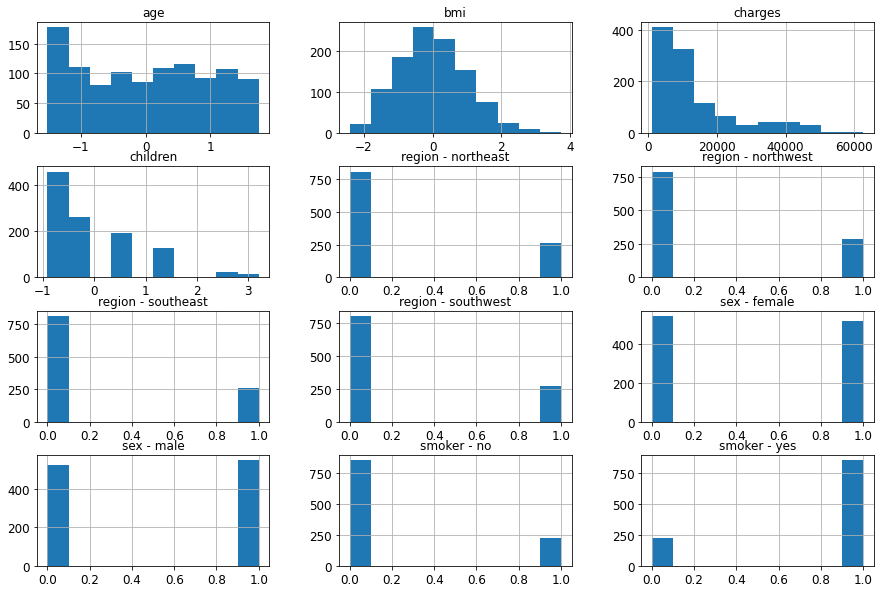

In [ ]:
train_prepared.hist(figsize=(15,10))
plt.show()

Finally, we form our X and y matrices by respectively dropping and selecting the label column from our data. It is essential that we apply our pipeline to the test set, or else our evaluation will be invalid.

In [ ]:
X_train = train_prepared.drop(label_name, axis=1)
y_train = train_prepared[[label_name]]

In [ ]:
test_prepared = pd.DataFrame(full_pipeline.fit_transform(test), columns=columns_reordered)

In [ ]:
X_test = test_prepared.drop(label_name, axis=1)
y_test = test_prepared[[label_name]]

- - -
## Step 3: Gradient Descent
We implement gradient descent for linear regression below, taking care to insert a column of 1s for our $\textbf{x}_0$ intercept on a copy of the user's data.


In [ ]:
class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    # parameter vector - initialized to random floats
    self.theta = np.random.randn(X_train.shape[1]+1, 1)

    # learning rate - initialized to a good default
    self.alpha = 0.001;

    # cost history - initialized to empty list
    self.cost  = [];

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # Add x0 column
    X = X_train.copy()
    X.insert(0, 'dummy', 1)

    m = X.shape[1]
    cost = []

    for iter in range(iters):
      gradients = 2/m * X.T.dot(X.dot(theta).values - y_train)
      theta -= alpha * gradients

      diff = (X.dot(theta) - y_train).values
      cost_iter = np.linalg.norm(1/m * diff.T * diff)
      cost.append(cost_iter)

    return theta, cost

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    m = X_train.shape[1]+1 # add one for intercept
    self.theta = np.random.randn(m, 1)
    self.theta, self.cost = self.gradientDescent(X_train, y_train, self.theta, self.alpha, 200)

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # Add x0 column
    X = X_train.copy()
    X.insert(0, 'dummy', 1)

    self.theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y_train).flatten()

  def predict(self, X_test):
    """
    Predicting the label
    """
    # Add x0 column
    X = X_test.copy()
    X.insert(0, 'dummy', 1)
    
    y_predict = X.dot(self.theta)
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    return f"Parameter vector is {self.theta}"


**Learning Rate:** We try out different learning rates for the dataset to find a learning rate that converges quickly. 

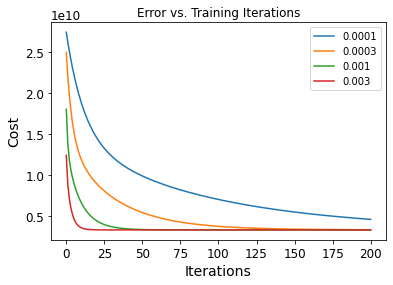

In [ ]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
alphas = [0.0001, 0.0003, 0.001, 0.003]
models = {}

for alpha in alphas:

  # Train model
  model_gd = MyLinearRegression()
  model_gd.alpha = alpha
  model_gd.fitUsingGradientDescent(X_train, y_train)
  iters = len(model_gd.cost)
  models[model_gd.cost[-1]] = (model_gd, alpha)

  # Plot cost
  plt.plot(np.linspace(0, iters, num=iters), model_gd.cost)
  
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations') 
plt.legend(alphas)
plt.show()

We see that our gradient descent-based model converges quickest with a learning rate of 0.003 among the rates tested. We can also confirm that it achieves the lowest cost at the end of training. We select this model for evaluation.

In [ ]:
best_cost = np.min(list(models.keys())) # lowest final cost
myGradientDescentModel = models[best_cost][0] # model of lowest final cost
best_alpha = models[best_cost][1] # learning rate for that model

print("Best learning rate: ", best_alpha)
print("Lowest cost: ", best_cost)

Best learning rate:  0.003
Lowest cost:  3323926618.4300027


- - -
## Step 4: Normal Equation

Below is the closed-form solution for linear regression, known as the normal equation.

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

It is implemented in the regressor class above as an alternative method of finding the best-fit line.

In [ ]:
# Implement the normalEquation method of the MyLinearRegression Class before executing the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## Step 5: Model Evaluation

Next, we compare the gradient descent approach to the normal equation, also including Sklearn's Stochastic Gradient Descent model for good measure. We evaluate the models by computing their Root Mean Square Error on the test data.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.exceptions import DataConversionWarning
from sklearn.utils.testing import ignore_warnings

@ignore_warnings(category=DataConversionWarning)
def evaluate(model, fit, name):
  fit(X_train, y_train)
  y_predict = model.predict(X_test)
  mse = mean_squared_error(y_test, y_predict)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_predict)
  print(name)
  print('RMSE: ', str(rmse))
  print('MAE: ', str(mae))
  print()

We can see that Sklearn's SGD model performs the best as measured by RMSE, but just barely. All models essentially hold the same predictive power, with our custom GD and Normal Equation-based models being near replicas.

An RMSE of ~5790 can be interpreted as indicating **a "typical" error of \$5790 dollars when predicting medical costs, biased upwards by outliers**. We also include Mean Average Error for comparison, which confirms that all models are highly similar but Sklearn's SGD regressor is slightly less susceptible to errors when modeling outliers. MAE indicates a true "average" error in either direction of \$4140.

Given that a median medical charge is $9382, **our linear models score poorly using either metric. None of them are ready to deploy for real-world use.**



In [ ]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
model_sgd = SGDRegressor(random_state=SEED)

evaluate(model_sgd, model_sgd.fit, 'Sklearn SGD Model')
evaluate(myGradientDescentModel, myGradientDescentModel.fitUsingGradientDescent, 'My GD Model (alpha: ' + str(best_alpha) + ')') 
evaluate(myNormalEquationModel, myNormalEquationModel.fitUsingNormalEquation, 'My Normal Eq. Model')

Sklearn SGD Model
RMSE:  5791.587879020164
MAE:  4141.152345577996

My GD Model (alpha: 0.003)
RMSE:  5795.33253302007
MAE:  4167.870547846676

My Normal Eq. Model
RMSE:  5795.332533018759
MAE:  4167.870547845393



- - -
## Step 6: The Solution

In this project, we develop a regressor capable of using either batch gradient descent or linear algebra to model linear relationships among variables. We apply this model to the task of predicting medical costs, which it does poorly as measured by RMSE.

However, this project moves us closer to our goal by uncovering important insights. By analyzing the coefficients of our linear model, we can assess the importance of different features on our predictions.

- The high-magnitude coefficients of the smoker (yes/no) features suggest that smoking has a strong predictive value for medical costs, which makes intuitive sense, as smoking has been linked to lung and other diseases. 

- Sex and age appear to matter a good deal in our modeling attempt, the latter of which supports our earlier conjecture during the data visualization process

- Similarly, the low coefficient for number of children reflects our earlier intuition that this feature is not very important for predictions

It may be worth investigating these findings with a nonlinear model, such as a random forest regressor, as a linear model clearly lacks the power to predict with low error. Based on our work during the visualization steps, it may also be useful to transform number of children into a binary categorical variable (less than 5 or not), or experiment with other feature engineering approaches. In particular, the age feature stands out as a good candidate for feature engineering, as our scatter plot shows multiple overlapping linear trends.

In [ ]:
coef = myGradientDescentModel.theta.sort_values(by='charges', ascending=False)
coef.columns = ['coefficient']
coef

,coefficient
smoker - no,16339.351214
dummy,9027.277564
sex - female,4522.791914
sex - male,4504.200222
age,3614.975415
region - southwest,2716.952966
region - southeast,2346.275640
region - northwest,2059.088670
bmi,2036.228123
region - northeast,1907.153612
